# Classifier

## Part 0: Packages requirement

opencv-python        4.1.2.30   
six                  1.13.0             
slim                 0.1                
tensorboard          2.0.2              
tensorflow           2.0.0              
tensorflow-estimator 2.0.1              
tensorflow-gpu       2.0.0   

In [126]:
#set PATH=C
#echo %PATH% 

# here is NETS package pwd
#PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
%env PYTHONPATH =  '~/models-master/research/slim'


env: PYTHONPATH='~/models-master/research/slim'


In [127]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import glob as gb


## Part 1: Preprocessing

In [128]:
def img_show_old(img,name):
    cv2.namedWindow(name, cv2.WINDOW_NORMAL)
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def img_show(img, code=cv2.COLOR_BGR2RGB):
    cv_rgb = cv2.cvtColor(img, code)
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.imshow(cv_rgb)
    fig.show()


In [129]:
def find_from(img):
    # Binarization
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary = cv2.adaptiveThreshold(~gray, 255, 
                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, -10)
    rows,cols=binary.shape
    scale = 20
    # horizontal lines
    kernel  = cv2.getStructuringElement(cv2.MORPH_CROSS,(cols//scale,1))
    eroded = cv2.erode(binary,kernel,iterations = 2)
    dilatedcol = cv2.dilate(eroded,kernel,iterations = 2)
    
    # vertical lines
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(1,rows//scale))
    eroded = cv2.erode(binary,kernel,iterations = 2)
    dilatedrow = cv2.dilate(eroded,kernel,iterations = 2)
    
    # get vertex
    vertex = cv2.bitwise_and(dilatedcol, dilatedrow)
    
    # get cell
    merge = cv2.add(dilatedcol,dilatedrow)
    return merge


In [130]:
def img_to_arr(img,x,y):
    img = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)).convert('L')
    #img.show()  
    #img = Image.open('iCard_021873_1_Daba_Ayehush_H-Copy1.jpg').convert('L')
    if img.size[0] != x or img.size[1] != y:
        img = img.resize((x, y))

    arr = []

    for i in range(y):
        for j in range(x):
            # mnist 里的颜色是0代表白色（背景），1.0代表黑色
            #print(img.getpixel((j, i)))
            pixel = 1.0 - float(img.getpixel((j, i)))/255.0
            # pixel = 255.0 - float(img.getpixel((j, i))) # 如果是0-255的颜色值
            arr.append(pixel)
            
    return arr

#img_to_arr(img_list[0],300,300)

In [131]:
img_path = sorted(gb.glob("Data/*.jpg"))
#Returns a list of all folders with participant numbers
img_list =[]
for path in img_path:
    img  = cv2.imread(path) 
    img_list.append(img)
    
text_list = []    
from_list = []
for img in img_list:
    text_list.append(img_to_arr(img,300,300))
    from_list.append(img_to_arr(find_from(img),300,300))  
    
np.array(text_list).shape

(120, 90000)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


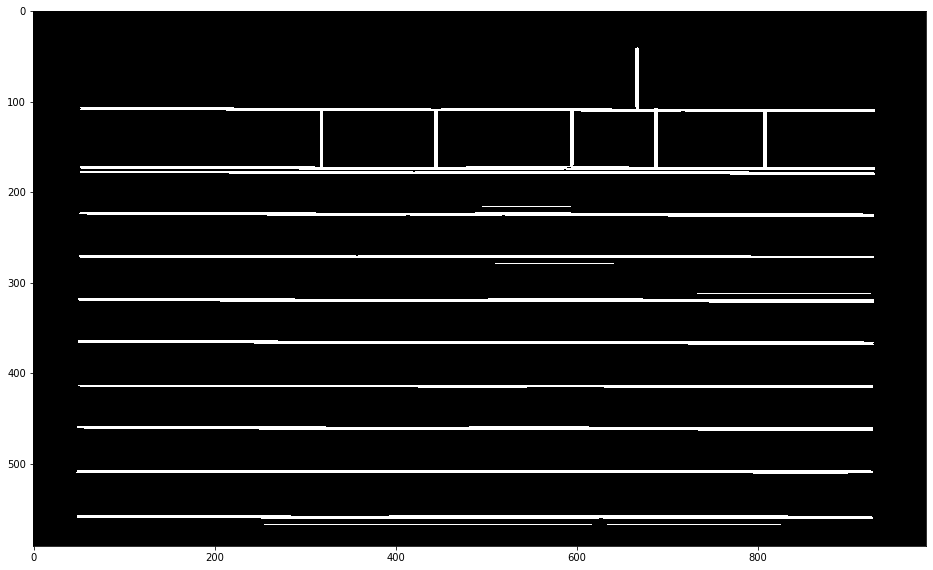

In [132]:
img_show(find_from(img_list[1]))

In [133]:
img_data = pd.read_csv('EAI6020ProjectDataFields.csv')

img_group_list = []
 
img_group = []
for form in np.array(img_data.iloc[:,[2]]).tolist():
    if(form == ["A"]):
        img_group.append([0])
    elif(form == ["B"]):
        img_group.append([1])
    elif(form == ["C"]):
        img_group.append([2])
img_group_list.append(img_group)   

img_group = []
for form in np.array(img_data.iloc[:,[3]]).tolist():
    if(form == ["N"]):
        img_group.append([0])
    elif(form == ["Y"]):
        img_group.append([1])
img_group_list.append(img_group)  

img_group = []
for form in np.array(img_data.iloc[:,[4]]).tolist():
    if(form == ["N"]):
        img_group.append([0])
    elif(form == ["Y"]):
        img_group.append([1])
img_group_list.append(img_group)   


len(img_group_list[1])

120

In [135]:
input_train = np.array(from_list)
input_train = input_train.reshape(input_train.shape[0], 300, 300, 1)
input_train.shape

input_train[0:120].shape

(120, 300, 300, 1)

## Part 2: Modeling

In [136]:
'''
  Keras CNN
'''
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import activations

# Model configuration
img_width, img_height = 500, 500
batch_size = 250
no_epochs = 100
no_classes = 3
validation_split = 0.2
verbosity = 1

def kares_data(input_data,input_target,img_width,img_height,no_classes):
        # Load dataset
    input_data = np.array(input_data)
    input_train = input_data[0:100]
    target_train = input_target[0:100]
    
    input_test = input_data[100:120]
    target_test = input_target[100:120]
    
    # Reshape data based on channels first / channels last strategy.
    # This is dependent on whether you use TF, Theano or CNTK as backend.
    # Source: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
    if K.image_data_format() == 'channels_first':
        input_train = input_train.reshape(input_train.shape[0], 1, img_width, img_height)
        input_test = input_test.reshape(input_test.shape[0], 1, img_width, img_height)
        input_shape = (1, img_width, img_height)
    else:
        input_train = input_train.reshape(input_train.shape[0], img_width, img_height, 1)
        input_test = input_test.reshape(input_test.shape[0], img_width, img_height, 1)
        input_shape = (img_width, img_height, 1)
    
    # Parse numbers as floats
    input_train = input_train.astype('float32')
    input_test = input_test.astype('float32')
    
    # Normalize data
    input_train = input_train / 255
    input_test = input_test / 255
    
    # Convert target vectors to categorical targets
    target_train = keras.utils.to_categorical(target_train, no_classes)
    target_test = keras.utils.to_categorical(target_test, no_classes)
    
    return input_train,input_test,target_train,target_test,input_shape
    
def kares_setup(input_train,input_test,target_train,target_test,input_shape,img_width, img_height,batch_size,no_epochs,no_classes,validation_split,verbosity):
    
    # Create the model
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(no_classes, activation='softmax'))
    
    # Compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

    # Fit data to model
    model.fit(input_train, target_train,
          batch_size=batch_size,
          epochs=no_epochs,
          verbose=verbosity,
          validation_split=validation_split)

    # Generate generalization metrics
    score = model.evaluate(input_test, target_test, verbose=0)
    print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
    
    return model



In [138]:
# Form classification
input_train,input_test,target_train,target_test,input_shape = kares_data(from_list,img_group_list[0],300,300,3)

tensorflow.keras.backend.clear_session()

model_form = kares_setup(input_train,input_test,target_train,target_test,input_shape, 300, 300, 250, 50, 3 , 0.2 ,1)

model_form.save('model_form_1.h5')

Train on 80 samples, validate on 20 samples
Epoch 1/50
80/80 [==============================] - 3s 41ms/sample - loss: 1.0986 - accuracy: 0.3750 - val_loss: 1.0210 - val_accuracy: 0.5500
Epoch 2/50
80/80 [==============================] - 2s 25ms/sample - loss: 1.0916 - accuracy: 0.3750 - val_loss: 1.0652 - val_accuracy: 0.5500
Epoch 3/50
80/80 [==============================] - 2s 25ms/sample - loss: 1.0869 - accuracy: 0.3750 - val_loss: 1.0327 - val_accuracy: 0.5500
Epoch 4/50
80/80 [==============================] - 2s 26ms/sample - loss: 1.0754 - accuracy: 0.3750 - val_loss: 0.9968 - val_accuracy: 0.5500
Epoch 5/50
80/80 [==============================] - 2s 25ms/sample - loss: 1.0590 - accuracy: 0.3750 - val_loss: 1.0407 - val_accuracy: 0.8000
Epoch 6/50
80/80 [==============================] - 2s 25ms/sample - loss: 1.0348 - accuracy: 0.7250 - val_loss: 1.0143 - val_accuracy: 0.5500
Epoch 7/50
80/80 [==============================] - 2s 24ms/sample - loss: 1.0302 - accuracy: 0.37

Test : C Predict : C


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


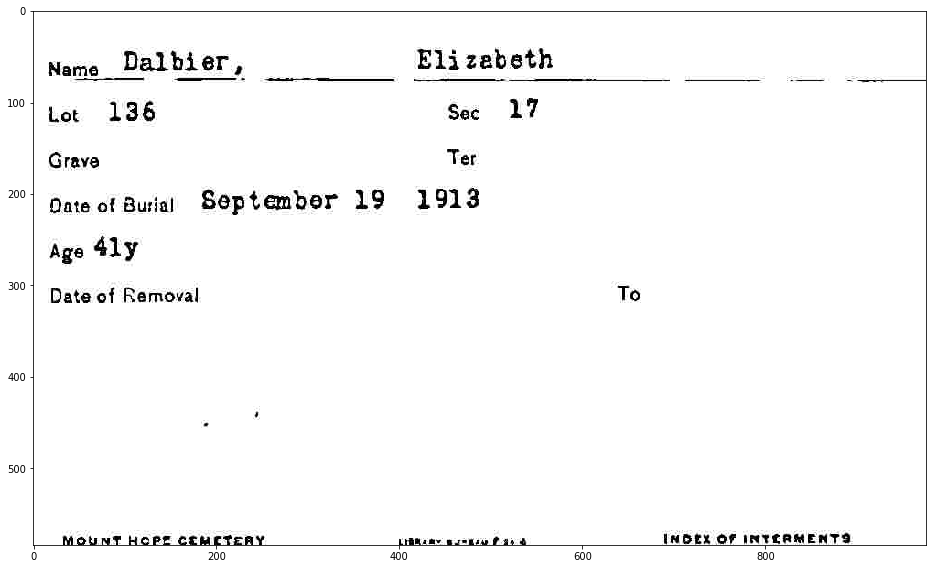

In [12]:
predata = model.predict(input_test)
rel_class = img_group_list[0][100:120]
rel_img = img_list[100:120]
#for i in predata:
#    print(np.where(i == np.max(i)))
def num_to_class(rel):
    clas = "NaN"
    if(rel == [0]):
        clas = "A"
    elif(rel == [1]):
        clas = "B"
    elif(rel == [2]):
        clas = "C"
    return clas

def step_test_model(predata,rel_class,rel_img,i):
    rel = np.where(predata[i] == np.max(predata[i]))
    print("Test :",num_to_class(rel_class[i]),"Predict :",num_to_class(rel[0]))
    img_show(rel_img[i])    

step_test_model(predata,rel_class,rel_img,17)


for i in range(len(predata)):
    rel = np.where(predata[i] == np.max(predata[i]))
    # print(num_to_class(rel_class[i]),num_to_class(rel[0]))
    
